In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [33]:
data = pd.read_csv('economic_times_sentiment.csv')
data.head()

,headline,sentiment
0,"Amazon's founder Jeff Bezos to step down as CEO, Andy Jassy to take over",Neutral
1,"WhatsApp Pay was possible because of India's UPI system, a first in the world: Mark Zuckerberg in conversation with Mukesh Ambani",Negative
2,FB-Jio will help digital platforms value creation in India: Mukesh Ambani in conversation with Mark Zuckerberg,Positive
3,Microsoft allows employees to work from home permanently,Neutral
4,"Instagram turns 10, launches new well-being features",Neutral


*Обработка текста не особо улучшила показатели:
только на tf-idf f1-score стал в среднем на 0,01 п.п. выше.*

In [34]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

from pymystem3 import Mystem
stem = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
def preprocessing(text):
    text = text.lower()
    text = re.sub('\n', ' ', text)
    text = stem.lemmatize(text)
    text = re.sub(r'\W', ' ', str(text)).split()
    text = [word for word in text if word not in stop_words and word[0].isalpha()]
    text_f = ' '.join(text)
    return text_f

In [36]:
data['preprocessed_headline'] = data['headline'].apply(preprocessing)

In [37]:
data

,headline,sentiment,preprocessed_headline
0,"Amazon's founder Jeff Bezos to step down as CEO, Andy Jassy to take over",Neutral,amazon founder jeff bezos step ceo andy jassy take n
1,"WhatsApp Pay was possible because of India's UPI system, a first in the world: Mark Zuckerberg in conversation with Mukesh Ambani",Negative,whatsapp pay possible india upi system first world mark zuckerberg conversation mukesh ambani n
2,FB-Jio will help digital platforms value creation in India: Mukesh Ambani in conversation with Mark Zuckerberg,Positive,fb jio help digital platforms value creation india mukesh ambani conversation mark zuckerberg n
3,Microsoft allows employees to work from home permanently,Neutral,microsoft allows employees work home permanently n
4,"Instagram turns 10, launches new well-being features",Neutral,instagram turns launches new well features n
...,...,...,...
2503,"Brookfield to invest Rs 25,215 crore in Reliance Jio tower unit",Neutral,brookfield invest rs crore reliance jio tower unit n
2504,Reliance Jio Q1 profit jumps 46% YoY to Rs 891 crore,Positive,reliance jio q1 profit jumps yoy rs crore n
2505,"Reliance Q1 results: Profit rises 7% to Rs 10,104 crore",Positive,reliance q1 results profit rises rs crore n
2506,"IndiGo posts highest-ever quarterly profit of Rs 1,203 crore in Q1",Positive,indigo posts highest ever quarterly profit rs crore q1 n


In [38]:
data.sentiment.value_counts()

sentiment
Neutral     1225
Positive     881
Negative     402
Name: count, dtype: int64

*Балансировка классов не улучшила результат, в некоторых моделях показатели даже хуже стали, поэтому убрала её*.

In [39]:
X = data['preprocessed_headline']
y = data['sentiment'].tolist()

**Разделение на тестовую и тренировочную выборки.**

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split (X, y, stratify=y,shuffle=True,test_size=0.2, random_state=25)

**Векторизация**

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [43]:
tf_idf = TfidfVectorizer()

In [44]:
tf_idf.fit(X_train)

TfidfVectorizer()

In [45]:
X_train_tf = tf_idf.transform(X_train)
X_test_tf =  tf_idf.transform(X_test)

In [46]:
count = CountVectorizer()

In [47]:
count.fit(X_train)

CountVectorizer()

In [48]:
X_train_c = count.transform(X_train)
X_test_c =  count.transform(X_test)

In [49]:
from sklearn.preprocessing import LabelEncoder

In [50]:
le = LabelEncoder()

In [51]:
le.fit(y_train)

LabelEncoder()

In [52]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [53]:
y_train_le = le.transform(y_train)
y_test_le = le.transform(y_test)

**Логистическая регрессия с использованием tf-idf и CV**

**TF**-**IDF**

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
log_tf = LogisticRegression(random_state=0, max_iter=500)

In [56]:
log_tf.fit(X_train_tf, y_train_le)

LogisticRegression(max_iter=500, random_state=0)

In [57]:
y_predict_log_tf = log_tf.predict(X_test_tf)

In [58]:
print(classification_report(y_test_le, y_predict_log_tf , target_names = le.classes_))

              precision    recall  f1-score   support

    Negative       0.84      0.32      0.46        81
     Neutral       0.67      0.90      0.77       245
    Positive       0.78      0.61      0.69       176

    accuracy                           0.71       502
   macro avg       0.76      0.61      0.64       502
weighted avg       0.73      0.71      0.69       502



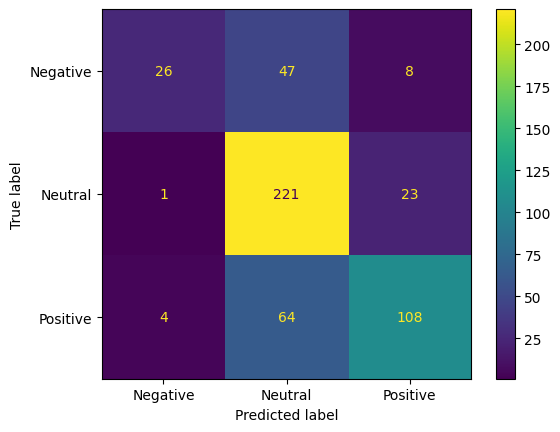

In [59]:
cm_log_tf = confusion_matrix(y_test_le, y_predict_log_tf)
cm_display_log_tf = ConfusionMatrixDisplay(cm_log_tf, display_labels=le.classes_).plot()

**CountVectorizer**

In [60]:
log_cv = LogisticRegression(random_state=0, max_iter=1000)

In [61]:
log_cv.fit(X_train_c, y_train_le)

LogisticRegression(max_iter=1000, random_state=0)

In [62]:
y_pred_log_cv = log_cv.predict(X_test_c)

In [63]:
print(classification_report(y_test_le, y_pred_log_cv, target_names = le.classes_))

              precision    recall  f1-score   support

    Negative       0.74      0.40      0.52        81
     Neutral       0.69      0.91      0.78       245
    Positive       0.80      0.62      0.70       176

    accuracy                           0.73       502
   macro avg       0.75      0.64      0.67       502
weighted avg       0.74      0.73      0.71       502



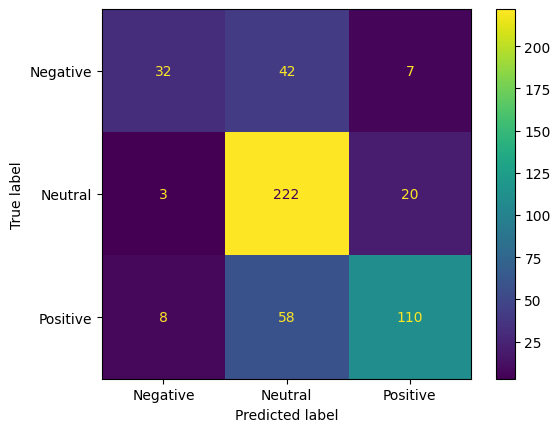

In [64]:
cm_log_cv = confusion_matrix(y_test_le, y_pred_log_cv)
cm_display_log_cv = ConfusionMatrixDisplay(cm_log_cv, display_labels=le.classes_).plot()

**Обучение решающего дерева**

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
tree_m = DecisionTreeClassifier()

**TF-IDF**

In [67]:
tree_m.fit(X_train_tf, y_train_le)

DecisionTreeClassifier()

In [68]:
tree_y_pred_t = tree_m.predict(X_test_tf)

In [69]:
tree_y_pred_t

array([2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1,
       0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1,
       1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 0, 2, 2, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 1, 1, 2,
       0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1,
       0, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2,
       1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 2, 1, 1, 0,
       1, 2, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,

In [70]:
print(classification_report(y_test_le, tree_y_pred_t))

              precision    recall  f1-score   support

           0       0.62      0.56      0.58        81
           1       0.76      0.86      0.80       245
           2       0.81      0.70      0.75       176

    accuracy                           0.75       502
   macro avg       0.73      0.70      0.71       502
weighted avg       0.75      0.75      0.75       502



In [51]:
print(confusion_matrix(y_test_le, tree_y_pred_t))

[[ 43  27  11]
 [ 17 208  20]
 [ 13  43 120]]


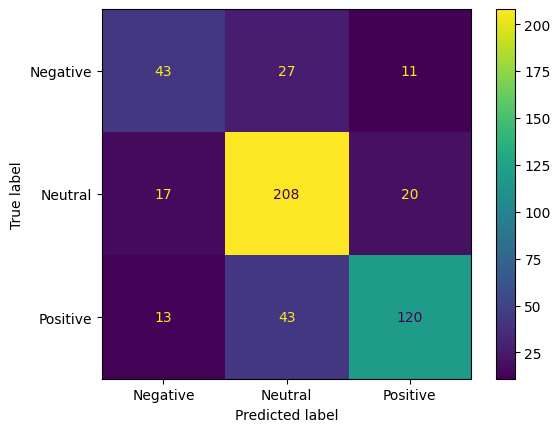

In [52]:
cm = confusion_matrix(y_test_le, tree_y_pred_t)
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()

**CountVectorizer**

In [53]:
tree_m.fit(X_train_c, y_train_le)

DecisionTreeClassifier()

In [54]:
tree_y_pred_c = tree_m.predict(X_test_c)

In [55]:
tree_y_pred_c

array([2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1,
       1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 0, 2, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
       0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1,
       0, 2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 0, 1, 2,
       1, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 1, 0, 2, 2, 0, 2, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 1,

In [56]:
print(classification_report(y_test_le, tree_y_pred_c))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63        81
           1       0.77      0.89      0.83       245
           2       0.85      0.73      0.79       176

    accuracy                           0.78       502
   macro avg       0.77      0.73      0.75       502
weighted avg       0.79      0.78      0.78       502



In [57]:
print(confusion_matrix(y_test_le, tree_y_pred_c))

[[ 46  25  10]
 [ 13 219  13]
 [  7  40 129]]


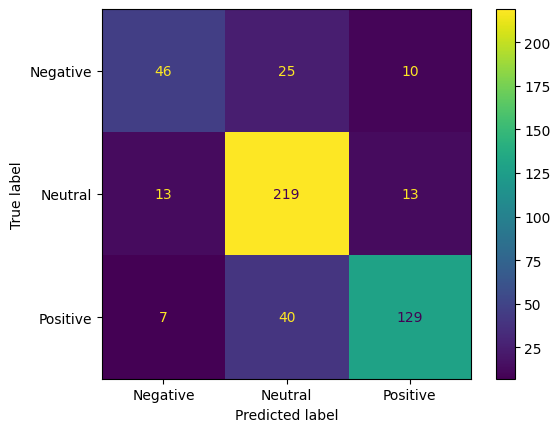

In [58]:
cm_tr_c = confusion_matrix(y_test_le, tree_y_pred_c)
cm_display = ConfusionMatrixDisplay(cm_tr_c, display_labels=le.classes_).plot()

# **Ансамбли**

**Random Forest**

In [71]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=1000, verbose=1)

**TF-IDF**

In [72]:
forest.fit(X_train_tf, y_train_le)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:   12.6s


RandomForestClassifier(n_estimators=1000, verbose=1)

In [73]:
forest_y_pred_t = forest.predict(X_test_tf)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s


In [74]:
forest_y_pred_t


array([2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 1,
       1, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
       0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0,
       1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,

In [64]:
print(classification_report(y_test_le, forest_y_pred_t))

              precision    recall  f1-score   support

           0       0.86      0.38      0.53        81
           1       0.70      0.95      0.80       245
           2       0.86      0.65      0.74       176

    accuracy                           0.75       502
   macro avg       0.81      0.66      0.69       502
weighted avg       0.78      0.75      0.74       502



In [65]:
confusion_matrix(y_test_le, forest_y_pred_t)

array([[ 31,  41,   9],
       [  3, 232,  10],
       [  2,  59, 115]])

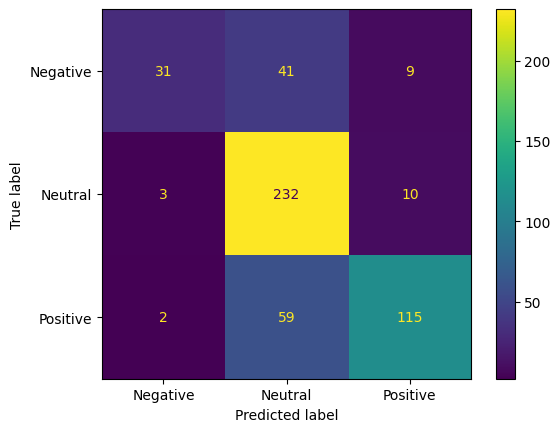

In [66]:
cm_f = confusion_matrix(y_test_le, forest_y_pred_t)
cm_display_f = ConfusionMatrixDisplay(cm_f, display_labels=le.classes_).plot()

**CountVectorizer**

In [67]:
forest.fit(X_train_c, y_train_le)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:   10.7s


RandomForestClassifier(n_estimators=1000, verbose=1)

In [68]:
forest_y_pred_c = forest.predict(X_test_c)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s


In [69]:
forest_y_pred_c

array([2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 1,
       1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
       0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0,
       1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,

In [70]:
print(classification_report(y_test_le, forest_y_pred_c))

              precision    recall  f1-score   support

           0       0.92      0.42      0.58        81
           1       0.71      0.97      0.82       245
           2       0.88      0.65      0.75       176

    accuracy                           0.77       502
   macro avg       0.84      0.68      0.72       502
weighted avg       0.81      0.77      0.76       502



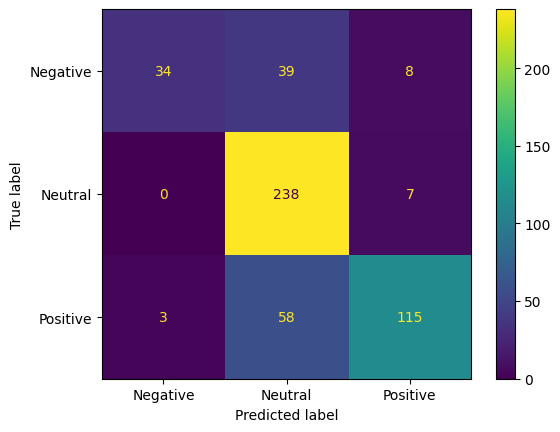

In [71]:
cm_f_c = confusion_matrix(y_test_le, forest_y_pred_c)
cm_display_f = ConfusionMatrixDisplay(cm_f_c, display_labels=le.classes_).plot()

**Boosting**

**TF-IDF**

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
boost = GradientBoostingClassifier(n_estimators=1000, random_state=20, verbose=10)

In [74]:
boost.fit(X_train_tf, y_train_le)

      Iter       Train Loss   Remaining Time 
         1           0.9736           39.55s
         2           0.9459           37.89s
         3           0.9236           35.93s
         4           0.9045           34.95s
         5           0.8886           35.34s
         6           0.8746           38.84s
         7           0.8625           38.41s
         8           0.8511           38.11s
         9           0.8410           37.59s
        10           0.8317           36.91s
        11           0.8236           36.41s
        12           0.8161           36.40s
        13           0.8087           36.19s
        14           0.8020           36.05s
        15           0.7952           35.93s
        16           0.7888           35.57s
        17           0.7834           35.44s
        18           0.7783           35.28s
        19           0.7734           35.37s
        20           0.7681           35.44s
        21           0.7635           35.20s
        2

GradientBoostingClassifier(n_estimators=1000, random_state=20, verbose=10)

In [75]:
boost_y_pred = boost.predict(X_test_tf)

In [76]:
print(classification_report(y_test_le, boost_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.54      0.65        81
           1       0.74      0.95      0.83       245
           2       0.89      0.68      0.77       176

    accuracy                           0.79       502
   macro avg       0.81      0.72      0.75       502
weighted avg       0.80      0.79      0.78       502



**CountVectorizer**

In [77]:
boost.fit(X_train_c, y_train_le)

      Iter       Train Loss   Remaining Time 
         1           0.9740           25.16s
         2           0.9467           24.49s
         3           0.9250           25.19s
         4           0.9070           25.20s
         5           0.8909           24.91s
         6           0.8776           24.86s
         7           0.8656           24.73s
         8           0.8546           25.90s
         9           0.8454           25.52s
        10           0.8361           25.07s
        11           0.8281           24.77s
        12           0.8205           24.66s
        13           0.8136           24.52s
        14           0.8069           24.30s
        15           0.8002           24.15s
        16           0.7948           23.98s
        17           0.7897           24.10s
        18           0.7852           23.96s
        19           0.7799           23.95s
        20           0.7749           23.91s
        21           0.7706           23.88s
        2

GradientBoostingClassifier(n_estimators=1000, random_state=20, verbose=10)

In [78]:
boost_y_pred = boost.predict(X_test_c)

In [79]:
print(classification_report(y_test_le, boost_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.57      0.69        81
           1       0.76      0.97      0.85       245
           2       0.91      0.70      0.79       176

    accuracy                           0.81       502
   macro avg       0.84      0.75      0.78       502
weighted avg       0.83      0.81      0.80       502



**Подбор гиперпараметров GridSearch в Random Forest**

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
grid_params = {'max_depth': [2, 5, 10, None], 'max_features': [0.3, 'sqrt', 1.0], 'n_estimators': [10, 100, 500]}

In [73]:
grid = GridSearchCV(RandomForestClassifier(), grid_params, scoring='f1_weighted', verbose=5)

In [ ]:
grid.fit(X_train_c, y_train_le)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.545 total time=   0.1s
[CV 2/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.459 total time=   0.1s
[CV 3/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.484 total time=   0.1s
[CV 4/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.513 total time=   0.1s
[CV 5/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.476 total time=   0.1s
[CV 1/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.473 total time=   0.5s
[CV 2/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.441 total time=   0.6s
[CV 3/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.440 total time=   0.9s
[CV 4/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.489 total time=   0.9s
[CV 5/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.480 total time=   0.9s
[CV

In [75]:
grid.best_params_

{'max_depth': None, 'max_features': 1.0, 'n_estimators': 500}

In [76]:
grid_pred = grid.predict(X_test_c)

In [78]:
print(classification_report(y_test_le, grid_pred))

              precision    recall  f1-score   support

           0       0.86      0.52      0.65        81
           1       0.74      0.97      0.84       245
           2       0.90      0.69      0.78       176

    accuracy                           0.80       502
   macro avg       0.83      0.72      0.76       502
weighted avg       0.82      0.80      0.79       502



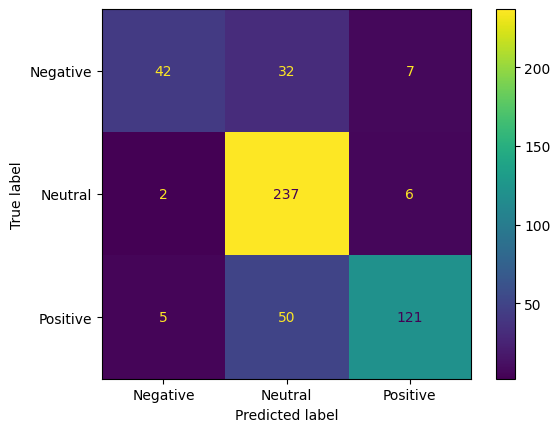

In [79]:
cm_g = confusion_matrix(y_test_le, grid_pred)
cm_g_display = ConfusionMatrixDisplay(cm_g, display_labels=le.classes_).plot()

In [80]:
grid.fit(X_train_tf, y_train_le)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.475 total time=   0.2s
[CV 2/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.465 total time=   0.2s
[CV 3/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.482 total time=   0.1s
[CV 4/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.530 total time=   0.1s
[CV 5/5] END max_depth=2, max_features=0.3, n_estimators=10;, score=0.518 total time=   0.1s
[CV 1/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.491 total time=   2.1s
[CV 2/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.441 total time=   1.7s
[CV 3/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.443 total time=   1.8s
[CV 4/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.490 total time=   0.8s
[CV 5/5] END max_depth=2, max_features=0.3, n_estimators=100;, score=0.481 total time=   0.5s
[CV

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 10, None],
                         'max_features': [0.3, 'sqrt', 1.0],
                         'n_estimators': [10, 100, 500]},
             scoring='f1_weighted', verbose=5)

In [82]:
grid.best_params_

{'max_depth': None, 'max_features': 1.0, 'n_estimators': 500}

In [83]:
grid_pred_tf = grid.predict(X_test_tf)

In [84]:
print(classification_report(y_test_le, grid_pred_tf))

              precision    recall  f1-score   support

           0       0.73      0.44      0.55        81
           1       0.72      0.95      0.82       245
           2       0.88      0.66      0.76       176

    accuracy                           0.77       502
   macro avg       0.78      0.69      0.71       502
weighted avg       0.78      0.77      0.76       502



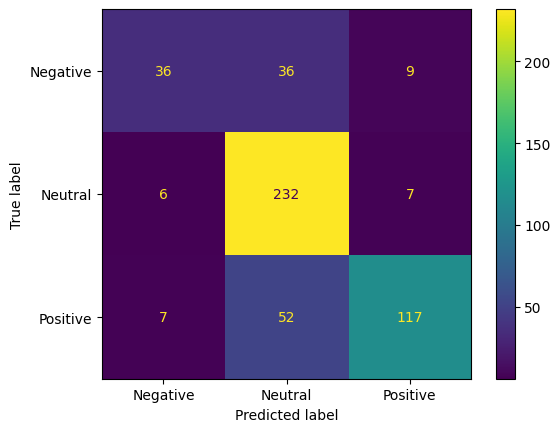

In [85]:
cm_g_tf = confusion_matrix(y_test_le, grid_pred_tf)
cm_g_display = ConfusionMatrixDisplay(cm_g_tf, display_labels=le.classes_).plot()

**Применение моделей на своём корпусе**

In [75]:
data_AI = pd.read_csv('AI_data_headers.csv')

In [76]:
data_AI

,headline
0,"MIT-Takeda Program wraps up with 16 publications, a patent, and nearly two dozen projects completed"
1,"Researchers leverage shadows to model 3D scenes, including objects blocked from view"
2,Understanding the visual knowledge of language models
3,A smarter way to streamline drug discovery
4,Technique improves the reasoning capabilities of large language models
...,...
1774,Uber will know if you're drunk before you even get in the car
1775,IBM computer taps AI to successfully debate humans
1776,Gen. Anthony Tata: One more reason to beware of the emerging China threat
1777,Researchers create a video game Mario that thinks for himself


**Использование Boosting и GridSearch на своём датасете**

**Boosting**

In [88]:
import joblib

In [90]:
joblib.dump(boost, "boost_model.pkl")
joblib.dump(count, "count.pkl")

['count.pkl']

In [91]:
loaded_model = joblib.load("boost_model.pkl")
loaded_vectorizer = joblib.load("count.pkl")

In [105]:
data_AI_c = loaded_vectorizer.transform(data_AI['headers'])

In [106]:
data_AI_c

<1779x4235 sparse matrix of type '<class 'numpy.int64'>'
	with 5984 stored elements in Compressed Sparse Row format>

In [107]:
predictions_boost = loaded_model.predict(data_AI_c)

In [124]:
data_AI['sentiment'] = predictions_boost

In [125]:
data_AI["sentiment"]=data_AI["sentiment"].map({2:'Positive',1:'Neutral',0:'Negative'})

In [126]:
data_AI_boost = data_AI

In [127]:
data_AI_boost

,headers,sentiment
0,MIT-Takeda Program wraps up with 16 publicatio...,Neutral
1,Researchers leverage shadows to model 3D scene...,Neutral
2,Understanding the visual knowledge of language...,Neutral
3,A smarter way to streamline drug discovery,Neutral
4,Technique improves the reasoning capabilities ...,Neutral
...,...,...
1774,Uber will know if you're drunk before you even...,Neutral
1775,IBM computer taps AI to successfully debate hu...,Neutral
1776,Gen. Anthony Tata: One more reason to beware o...,Negative
1777,Researchers create a video game Mario that thi...,Neutral


**GridSearch**

In [128]:
forest_grid = RandomForestClassifier(max_depth = None, max_features = 1.0, n_estimators=500)

In [129]:
joblib.dump(forest, "forest_grid.pkl")

['forest_grid.pkl']

In [130]:
loaded_model_f = joblib.load("forest_grid.pkl")

In [131]:
predictions_forest_grid = loaded_model_f.predict(data_AI_c)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.3s


In [132]:
data_AI['sentiment'] = predictions_forest_grid

In [133]:
data_AI["sentiment"]=data_AI["sentiment"].map({2:'Positive',1:'Neutral',0:'Negative'})

In [134]:
data_AI_forest_grid = data_AI

In [135]:
data_AI_forest_grid

,headers,sentiment
0,MIT-Takeda Program wraps up with 16 publicatio...,Neutral
1,Researchers leverage shadows to model 3D scene...,Neutral
2,Understanding the visual knowledge of language...,Neutral
3,A smarter way to streamline drug discovery,Neutral
4,Technique improves the reasoning capabilities ...,Neutral
...,...,...
1774,Uber will know if you're drunk before you even...,Neutral
1775,IBM computer taps AI to successfully debate hu...,Neutral
1776,Gen. Anthony Tata: One more reason to beware o...,Neutral
1777,Researchers create a video game Mario that thi...,Neutral


**Использование AutoGluon**

In [83]:
!pip install autogluon

In [84]:
!python -m pip install --upgrade pip
!python -m pip install autogluon

In [85]:
data_train, data_test = train_test_split(data[['headline','sentiment']], test_size=0.2, random_state=42)

In [95]:
from autogluon.tabular import TabularDataset, TabularPredictor
predictor = TabularPredictor(label='sentiment', problem_type="multiclass").fit(data_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20240629_001444"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Tue Jun 18 14:18:04 UTC 2024
CPU Count:          2
Memory Avail:       9.98 GB / 12.67 GB (78.8%)
Disk Space Avail:   75.76 GB / 107.72 GB (70.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fa

In [88]:
y_pred = predictor.predict(data_test)

In [90]:
y_pred.head(100)

2121     Neutral
56       Neutral
2480    Positive
1292     Neutral
1599     Neutral
          ...   
1258     Neutral
43       Neutral
1553    Negative
637      Neutral
2331    Positive
Name: sentiment, Length: 100, dtype: object

In [91]:
predictor.evaluate(data_test)

{'accuracy': 0.6235059760956175,
 'balanced_accuracy': 0.4886765677428328,
 'mcc': 0.35029725714894694}

In [92]:
predictor.leaderboard(data_test)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.639442,0.619403,accuracy,0.015300,0.004576,1.078589,0.015300,0.004576,1.078589,1,True,5
1,CatBoost,0.637450,0.626866,accuracy,0.024384,0.004196,4.277277,0.024384,0.004196,4.277277,1,True,8
2,LightGBMXT,0.627490,0.629353,accuracy,0.016329,0.004597,1.091151,0.016329,0.004597,1.091151,1,True,4
3,LightGBMLarge,0.627490,0.619403,accuracy,0.019987,0.005813,3.043601,0.019987,0.005813,3.043601,1,True,13
4,XGBoost,0.625498,0.621891,accuracy,0.059206,0.006532,1.489447,0.059206,0.006532,1.489447,1,True,11
5,WeightedEnsemble_L2,0.623506,0.631841,accuracy,0.079755,0.012595,2.895559,0.004220,0.001465,0.314960,2,True,14
6,RandomForestEntr,0.609562,0.577114,accuracy,0.239199,0.148950,2.938919,0.239199,0.148950,2.938919,1,True,7
7,ExtraTreesGini,0.597610,0.604478,accuracy,0.214117,0.097104,1.415505,0.214117,0.097104,1.415505,1,True,9
8,ExtraTreesEntr,0.591633,0.604478,accuracy,0.174591,0.108058,1.385295,0.174591,0.108058,1.385295,1,True,10
9,RandomForestGini,0.581673,0.584577,accuracy,0.252431,0.162577,1.870084,0.252431,0.162577,1.870084,1,True,6


**Использование на своих данных**

In [93]:
predictions = predictor.predict(data_AI)

In [96]:
predictions

0       Positive
1        Neutral
2        Neutral
3        Neutral
4        Neutral
          ...   
1774     Neutral
1775     Neutral
1776     Neutral
1777    Positive
1778     Neutral
Name: sentiment, Length: 1779, dtype: object

In [98]:
data_AI['predicted_label'] = predictions

In [99]:
data_AI

,headline,predicted_label
0,"MIT-Takeda Program wraps up with 16 publications, a patent, and nearly two dozen projects completed",Positive
1,"Researchers leverage shadows to model 3D scenes, including objects blocked from view",Neutral
2,Understanding the visual knowledge of language models,Neutral
3,A smarter way to streamline drug discovery,Neutral
4,Technique improves the reasoning capabilities of large language models,Neutral
...,...,...
1774,Uber will know if you're drunk before you even get in the car,Neutral
1775,IBM computer taps AI to successfully debate humans,Neutral
1776,Gen. Anthony Tata: One more reason to beware of the emerging China threat,Neutral
1777,Researchers create a video game Mario that thinks for himself,Positive
